importing the libraries

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

Importing the data

In [2]:
data_=lambda dates:pd.datetime.strptime(dates, '%Y-%m-%d')

Using the Date column as index

In [36]:
data= pd.read_csv("Sunspots.csv", parse_dates=['Date'], index_col=['Date'] , date_parser=data_)

C:\Users\HP\anaconda3\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


Remove the column " Unnamed : 0"

In [37]:
data=data.drop(columns=['Unnamed: 0'])

In [38]:
data.dtypes

Monthly Mean Total Sunspot Number    float64
dtype: object

In [39]:
data

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


Assigning values to series

In [42]:
series=data.iloc[:,0].values

In [43]:
print(np.array(series))

[ 96.7 104.3 116.7 ...   0.4   0.5   1.6]


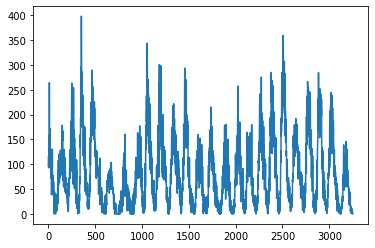

In [45]:
plt.plot(series)

In [10]:
print(np.array(time))

['1749-01-31T00:00:00.000000000' '1749-02-28T00:00:00.000000000'
 '1749-03-31T00:00:00.000000000' ... '2019-10-31T00:00:00.000000000'
 '2019-11-30T00:00:00.000000000' '2019-12-31T00:00:00.000000000']


In [46]:
def plot_series( Series):
    plt.figure(figsize=(10,6))
    plt.plot( Series)
    plt.xlabel("Time")
    plt.ylabel("Number of Sunspots")
    plt.title("Number of Sunspots in different Time" )
    plt.show()

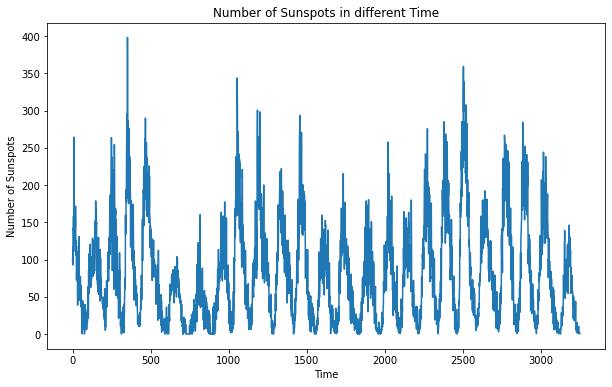

In [47]:
plot_series( series)

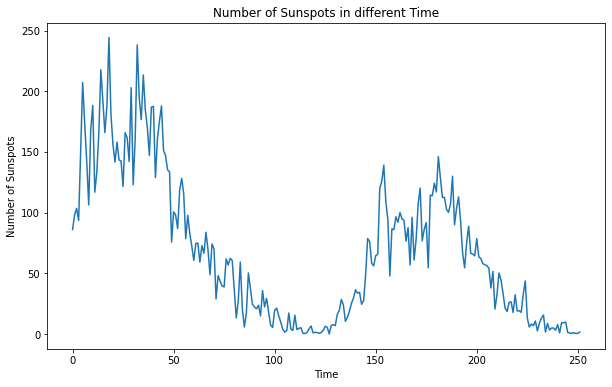

In [48]:
plot_series( series[3000:])

In [26]:
len(data)

3252

In [49]:
data.index

DatetimeIndex(['1749-01-31', '1749-02-28', '1749-03-31', '1749-04-30',
               '1749-05-31', '1749-06-30', '1749-07-31', '1749-08-31',
               '1749-09-30', '1749-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=3252, freq=None)

Splitting data into training and validation sets

In [50]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Defining the parameters

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [54]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [55]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


Defining the model

In [56]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 21s 2s/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 9s 710ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 11s 885ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 8s 666ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 8s 633ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 9s 761ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 10s 839ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 11s 934ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 10s 808ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/12 [==============================] - 9s 716ms/step - loss: 52.5681 - mae: 52.8302
Epoch 11/100
12/1

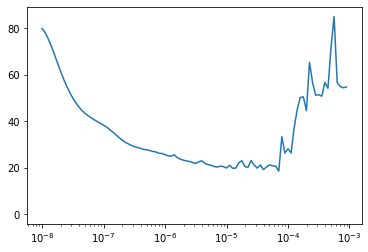

In [57]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.plot(1e-8, 1e-3,0, 60)

Traing the model after hyperparameter tuning

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 14s 480ms/step - loss: 47.3038 - mae: 48.1595
Epoch 2/500
30/30 [==============================] - 6s 213ms/step - loss: 24.8665 - mae: 25.4338
Epoch 3/500
30/30 [==============================] - 6s 211ms/step - loss: 21.4059 - mae: 21.9065
Epoch 4/500
30/30 [==============================] - 6s 207ms/step - loss: 20.9755 - mae: 21.4677
Epoch 5/500
30/30 [==============================] - 6s 212ms/step - loss: 21.3493 - mae: 21.8017
Epoch 6/500
30/30 [==============================] - 6s 210ms/step - loss: 19.9049 - mae: 20.3902 1s - loss: 19.9046 - mae: 20
Epoch 7/500
30/30 [==============================] - 6s 211ms/step - loss: 18.8861 - mae: 19.3919
Epoch 8/500
30/30 [==============================] - 6s 212ms/step - loss: 18.4420 - mae: 18.9523
Epoch 9/500
30/30 [==============================] - 7s 219ms/step - loss: 18.3772 - mae: 18.8492 0s - loss: 18.3600 - mae: 18.85
Epoch 10/500
30/30 [==============================] - 6s

30/30 [==============================] - 9s 285ms/step - loss: 16.2293 - mae: 16.7235
Epoch 162/500
30/30 [==============================] - 8s 281ms/step - loss: 16.1773 - mae: 16.6324
Epoch 163/500
30/30 [==============================] - 8s 266ms/step - loss: 16.2250 - mae: 16.7177
Epoch 164/500
30/30 [==============================] - 6s 207ms/step - loss: 16.2116 - mae: 16.6722
Epoch 165/500
30/30 [==============================] - 7s 239ms/step - loss: 16.1926 - mae: 16.6583
Epoch 166/500
30/30 [==============================] - 7s 231ms/step - loss: 16.2410 - mae: 16.7353
Epoch 167/500
30/30 [==============================] - 7s 234ms/step - loss: 16.3405 - mae: 16.8306
Epoch 168/500
30/30 [==============================] - 6s 214ms/step - loss: 16.2825 - mae: 16.7505
Epoch 169/500
30/30 [==============================] - 6s 209ms/step - loss: 16.1638 - mae: 16.6409
Epoch 170/500
30/30 [==============================] - 7s 223ms/step - loss: 16.1069 - mae: 16.6047
Epoch 171/500


30/30 [==============================] - 6s 216ms/step - loss: 15.5377 - mae: 15.9889
Epoch 323/500
30/30 [==============================] - 7s 236ms/step - loss: 15.5173 - mae: 16.0140
Epoch 324/500
30/30 [==============================] - 7s 237ms/step - loss: 15.4986 - mae: 15.9710
Epoch 325/500
30/30 [==============================] - 7s 242ms/step - loss: 15.5622 - mae: 16.0453
Epoch 326/500
30/30 [==============================] - 7s 236ms/step - loss: 15.6679 - mae: 16.1575
Epoch 327/500
30/30 [==============================] - 7s 226ms/step - loss: 15.5803 - mae: 16.0726
Epoch 328/500
30/30 [==============================] - 7s 231ms/step - loss: 15.4902 - mae: 15.9750
Epoch 329/500
30/30 [==============================] - 7s 228ms/step - loss: 15.5145 - mae: 15.9881
Epoch 330/500
30/30 [==============================] - 6s 216ms/step - loss: 15.4813 - mae: 15.9777
Epoch 331/500
30/30 [==============================] - 6s 209ms/step - loss: 15.5060 - mae: 16.0030
Epoch 332/500


30/30 [==============================] - 6s 211ms/step - loss: 14.8642 - mae: 15.3371
Epoch 483/500
30/30 [==============================] - 6s 210ms/step - loss: 14.8987 - mae: 15.3615
Epoch 484/500
30/30 [==============================] - 6s 208ms/step - loss: 14.9246 - mae: 15.4247
Epoch 485/500
30/30 [==============================] - 7s 222ms/step - loss: 14.9835 - mae: 15.4479
Epoch 486/500
30/30 [==============================] - 7s 225ms/step - loss: 14.9023 - mae: 15.3901
Epoch 487/500
30/30 [==============================] - 7s 217ms/step - loss: 15.2903 - mae: 15.7564
Epoch 488/500
30/30 [==============================] - 7s 217ms/step - loss: 14.9119 - mae: 15.4086
Epoch 489/500
30/30 [==============================] - 7s 225ms/step - loss: 14.9213 - mae: 15.4002
Epoch 490/500
30/30 [==============================] - 8s 257ms/step - loss: 14.8387 - mae: 15.3103
Epoch 491/500
30/30 [==============================] - 7s 233ms/step - loss: 14.8322 - mae: 15.3080
Epoch 492/500


In [60]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [61]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Visualization of the results

Text(0.5, 1.0, 'Number of Sunspots in time')

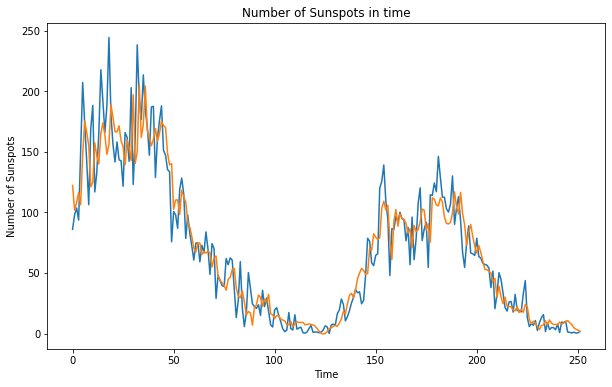

In [70]:
plt.figure(figsize=(10, 6))
plt.plot( x_valid)
plt.plot( rnn_forecast)
plt.ylabel("Number of Sunspots")
plt.xlabel("Time")
plt.title("Number of Sunspots in time")

In [69]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.094994

<Figure size 432x288 with 0 Axes>

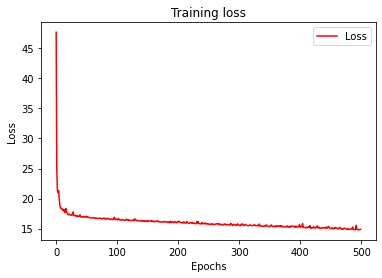

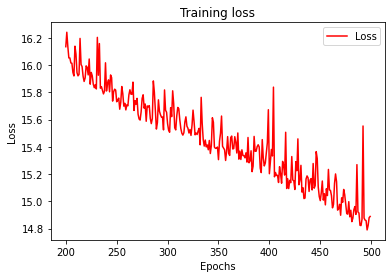

<Figure size 432x288 with 0 Axes>

In [71]:
import matplotlib.image  as mpimg

# Retrieve a list of results on training and test datasets for each training epoch

loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs



# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)



# Plot training and validation loss per epoch

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()